<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 5: Practical - Recurrent Neural Networks <br>
<font color=696880 size=4>
    Alireza Farashah, Parsa Hosseini
    
    
____


### Full Name : Naser Kazemi
### Student Number : 99102059
___

# Image Captioning using Recurrent Neural Networks
In this notebook we want to implement a deep neural network to caption Flickr images. It has 8091 images and each image in this dataset has an ID and there are 5 caption for each image in captions.txt file which is uploaded in Quera. We use pretrained ResNet50 model to get meaningful features from each image. Code of this part is implemented and you have to use id_to_feature and id_to_caption dictionary. See the code to understand what are these two dictionaries.
You have to implement the empty parts of this notebook.

# Import Libaries and Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ML/HW4/

/content/drive/MyDrive/ML/HW4


In [3]:
import os
import numpy as np
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

In [ ]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

In [ ]:
!unzip Flickr8k_Dataset.zip -d /images/

In [ ]:
!unzip captions.txt.zip -d text/

Archive:  /content/captions.txt.zip
  inflating: /content/text/captions.txt  


# Creeating Features and Captions Dcitionary

In [4]:
resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    pooling='avg'
)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
id_to_features = {}

for name in tqdm(os.listdir("images/Flicker8k_Dataset")):
    img = img_to_array(load_img("images/Flicker8k_Dataset/" + name, target_size=(224,224)))
    img = preprocess_input(img.reshape((1, img.shape[0], img.shape[1], img.shape[2])))
    feature = resnet50.predict(img, verbose=0)
    id_to_features[name.split('.')[0]]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [4]:
import pickle
# pickle.dump(id_to_features, open("features.pkl","wb"))
id_to_features = pickle.load(open("features.pkl","rb"))

In [ ]:
id_to_features['587604325_af5d6df679'].shape

(1, 2048)

In [ ]:
len(id_to_features)

8091

In [5]:
from itertools import islice

id_to_captions = {}

with open("text/captions.txt", 'r') as f:
    for i, line in enumerate(f):
        if i==0:
            continue
        tokens = line.split('.jpg,')
        id, caption = tokens[0], tokens[1]
        if id not in id_to_captions:
            id_to_captions[id] = []
        id_to_captions[id].append(caption) 

In [ ]:
len(id_to_captions)

8091

In [ ]:
id_to_captions['587604325_af5d6df679']

['A curly haired dog tries to bite another dog wearing a green and orange collar .\n',
 'One brown dog is bearing its teeth at another brown dog with a green collar in a park .\n',
 'Two brown dogs playing .\n',
 '"Two dogs , one with its mouth open ."\n',
 'Two golden dogs playing with one another\n']

# Preprocessing and Tokenizing (15 points)

In this part you need to clean the captions text in order to use Tokenizer.

In [6]:
import re
# preprocess caption texts
def preprocessing(captions: dict):
    for id, caption in captions.items():
        for i, cap in enumerate(caption):
            cap = re.sub(r"[^a-zA-Z0-9 ]+", '', cap)
            cap = re.sub(r"[ ]+", ' ', cap)
            caption[i] = '<start> ' + cap.lower().strip() + ' <end>'
    return captions


id_to_captions = preprocessing(id_to_captions)

In [7]:
# tokenize captions
def tokenize(captions: dict):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions.values())
    return tokenizer

In [8]:
# create vocabulary
from itertools import chain
all_captions = list(chain.from_iterable(id_to_captions.values()))
all_words = [word for caption in all_captions for word in caption.split()]
vocabulary = list(set(all_words))
vocabulary_size = len(vocabulary) + 1

In [9]:
word_to_index = {word: i + 1 for i, word in enumerate(vocabulary)}
index_to_word = {i + 1: word for i, word in enumerate(vocabulary)}
word_to_index['NULL'] = 0
index_to_word[0] = 'NULL'

caption_to_index = {}
for img_id, captions in id_to_captions.items():
    caption_to_index[img_id] = [[word_to_index[word]
                                for word in caption.split(" ")] for caption in captions]

max_len = 50
for img_id in caption_to_index:
    caption_to_index[img_id] = pad_sequences(caption_to_index[img_id], maxlen=max_len ,padding='post')

## Data Generator (25 points)

In this part implement a data generator function to use during the training.
For each image and caption you have to create number of train samples in the following format.

caption: "start_char the man is playing football end_char"

sample 0: X="start_char", Y="the "

sample 1: X="start_char the", Y="man"

...

sample n: X="start_char the man is playing football", Y="end_char"

In [10]:
# craete data generator 
def data_generator(caption_to_index, max_length, max_n):
    # insert your code here
    
    sequence = []
    features = []
    target = []
    n = 0
    
    for img_id in tqdm(caption_to_index):
        n += 1
        for i in range(len(caption_to_index[img_id])):
            for j in range(1, max_length):
                current_sequence = caption_to_index[img_id][i][:j]
                next_word = caption_to_index[img_id][i][j]
                current_sequence = pad_sequences([current_sequence], maxlen=max_length, padding='post')[0]
                one_hot_next_word = to_categorical([next_word], vocabulary_size)[0]
                sequence.append(current_sequence)
                features.append(id_to_features[img_id][0])
                target.append(one_hot_next_word)
        if n == max_n:
            yield [[np.array(features), np.array(sequence)], np.array(target)]
            sequence = []
            features = []
            target = []
            n = 0
            


## Model (20 points)

In [11]:
# define the model
# RNN model for image captioning
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


def create_model():
    # insert your code here
    input_features = Input(shape=(2048,))
    dense_1 = Dense(256, activation='relu')(input_features)
    dropout_1 = Dropout(0.5)(dense_1)
    
    input_sequence = Input(shape=(max_len,))
    embedding_1 = Embedding(vocabulary_size, 256, mask_zero=True)(input_sequence)
    lstm_1 = LSTM(256, return_sequences=True)(embedding_1)
    lstm_2 = LSTM(256, return_sequences=False)(lstm_1)
    
    add =  Add()([dropout_1, lstm_2])
    
    dense_3 = Dense(256, activation='relu')(add)
    output = Dense(vocabulary_size, activation='softmax')(dense_3)
    print(input_features.shape, input_sequence.shape)
    model = Model(inputs=[input_features, input_sequence], outputs=output)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model


model = create_model()
model.summary()


(None, 2048) (None, 50)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 256)      2260736     ['input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['input_1[0][0]']                
                                                                      

# Train (10 points)

Train the model and plot loss for training data.

In [12]:
# train the model
num_epochs = 10
num_captions = 5
max_n = 5
steps = len(caption_to_index) // num_captions
model_losses = []
model_accuracies = []
for i in range(num_epochs):
    generator = data_generator(caption_to_index, max_len, max_n)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_weights/model_' + str(i) + '.h5')
    model_losses.append(model.history.history['loss'])
    model_accuracies.append(model.history.history['accuracy'])

  0%|          | 0/8091 [00:00<?, ?it/s]

1618/1618 [==============================] - 131s 74ms/step - loss: 1.0835 - accuracy: 0.8213


  0%|          | 0/8091 [00:00<?, ?it/s]

1618/1618 [==============================] - 121s 75ms/step - loss: 0.8164 - accuracy: 0.8426


  0%|          | 0/8091 [00:00<?, ?it/s]

1618/1618 [==============================] - 121s 75ms/step - loss: 0.7498 - accuracy: 0.8476


  0%|          | 0/8091 [00:00<?, ?it/s]

1618/1618 [==============================] - 123s 76ms/step - loss: 0.7084 - accuracy: 0.8510


  0%|          | 0/8091 [00:00<?, ?it/s]

1618/1618 [==============================] - 121s 75ms/step - loss: 0.6780 - accuracy: 0.8534


  0%|          | 0/8091 [00:00<?, ?it/s]

1618/1618 [==============================] - 122s 76ms/step - loss: 0.6528 - accuracy: 0.8555


  0%|          | 0/8091 [00:00<?, ?it/s]

1618/1618 [==============================] - 122s 75ms/step - loss: 0.6308 - accuracy: 0.8573


  0%|          | 0/8091 [00:00<?, ?it/s]

1618/1618 [==============================] - 122s 76ms/step - loss: 0.6110 - accuracy: 0.8594


  0%|          | 0/8091 [00:00<?, ?it/s]

1618/1618 [==============================] - 123s 76ms/step - loss: 0.5937 - accuracy: 0.8614


  0%|          | 0/8091 [00:00<?, ?it/s]

1618/1618 [==============================] - 122s 75ms/step - loss: 0.5774 - accuracy: 0.8636


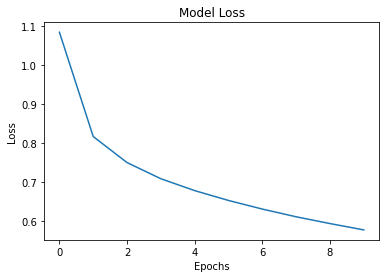

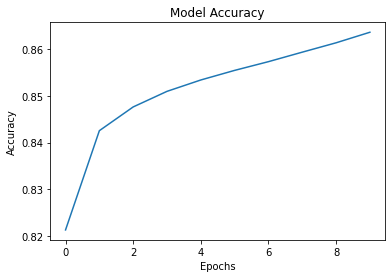

In [13]:
# plot loss and accuracy in each epoch
import matplotlib.pyplot as plt
plt.plot(model_losses)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(model_accuracies)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Test (30)

In this part evaluate the model and generate caption for 10 of test images. For evaluation use "bert-base-uncased" pretrained model and calculate similarity for the predicted sentence of model and real captions. 
Show 3 of the images and predictied samples.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluating our LSTM model with BERT embeddings


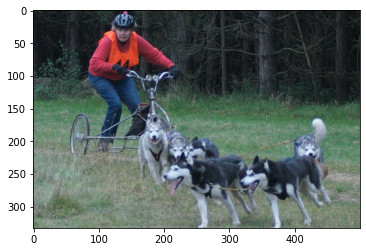

Actual Caption: ['a team of dogs and a woman following on a bike', 'a woman is riding a three wheeler bicycle behind a pack of dogs', 'a woman on a trike and a team of dogs', 'six huskies are pulling a three wheeled vehicle through the grass', 'woman being pulled on a large tricycle by several sled dogs']
Predicted Caption: a man in a red shirt is riding a horse down a dirt path
Similarity: 0.792723560333252



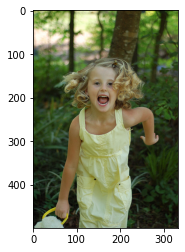

Actual Caption: ['a little blonde girl running outside', 'a little blonde girl wearing yellow laughing and running', 'a little girl in a yellow jumper runs holding a bucket', 'little girl with blond curly hair and wearing a yellow dress is jumping up', 'the young girl in the yellow dress is running in the garden area']
Predicted Caption: a young girl in a pink shirt is jumping into a pool
Similarity: 0.8514708995819091



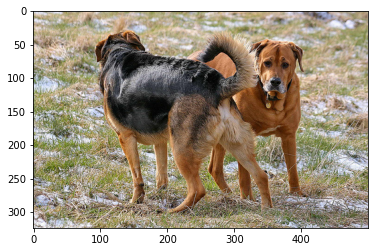

Actual Caption: ['a black and brown dog with a brown dog in a grassy field with patches of white', 'a black dog is facing a brown dog in an open outdoor space', 'two dogs are standing in a field of grass and dirt', 'two dogs greet each other in a snowy grass field', 'two dogs in a grassy field']
Predicted Caption: a dog is jumping up to catch a red ball
Similarity: 0.8191471219062805



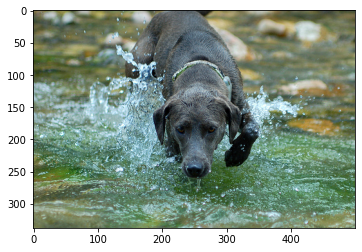

Actual Caption: ['a black dog splashes through greenish water', 'a black dog walking through splashing water in a rocky creek', 'a brown dog walks through a shallow stream', 'a greenish dog runs through the water by several large rocks', 'the dog walks in the shallow water']
Predicted Caption: a dog is jumping into a pond
Similarity: 0.8809932708740235



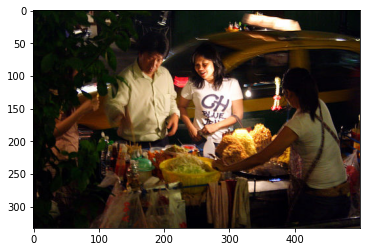

Actual Caption: ['a young couple inspect merchandise from a street vendor', 'people are gathering around a table of food and outside a taxi wisks by', 'three people prepare a table full of food with a police car in the background', 'two people look at a street vendor', 'two women and a man at a food counter in dim lights']
Predicted Caption: a man in a white shirt is standing next to a man wearing a white shirt and a white hat
Similarity: 0.7789124846458435



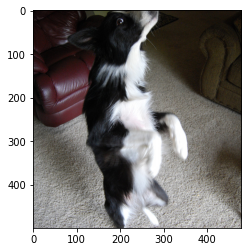

Actual Caption: ['a black and white dog standing on its hind legs on carpeting in front of a chair', 'a black and white dog stands on its hind legs', 'a boy jumps', 'black and white dog in living room standing on hind legs', 'closeup of a dog standing on its hind legs']
Predicted Caption: a black and white dog is playing with a red ball
Similarity: 0.8211021780967712



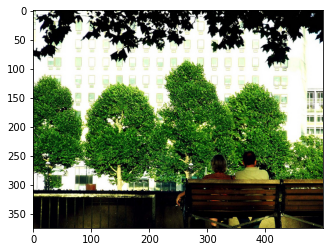

Actual Caption: ['a couple sits on a shaded bench with a view of trees and a large building', 'a couple sitting on a bench in a park', 'a man and a woman on a bench facing a building with trees along the front of it', 'two people are sitting on a wooden bench by trees in front of a white building', 'two people sit on a park bench admiring the trees and large building they face']
Predicted Caption: a man in a red shirt is sitting on a rock overlooking a lake
Similarity: 0.8409926295280457



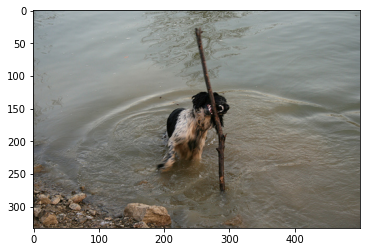

Actual Caption: ['a black and white dog with a stick is in muddy water', 'a dog is in some water with a tree branch in its mouth', 'a dog is plling a very large branch out of the water', 'a dog is walking through the water carrying a large stick in its mouth', 'black and white dog outdoors in muddy water with stick in mouth']
Predicted Caption: a dog is jumping into a pool
Similarity: 0.8566222786903381



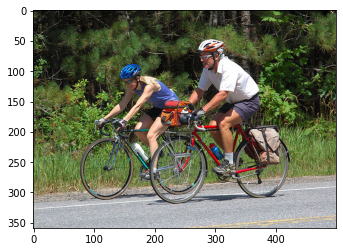

Actual Caption: ['a man and woman ride bicycles next to each other', 'two bikers bike along the street', 'two men riding bikes on highway', 'two people are riding bicycles along a road', 'two people riding their bikes down a street together']
Predicted Caption: a man in a red shirt is riding a bike in a race
Similarity: 0.8048545479774475



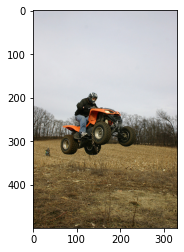

Actual Caption: ['a four wheeler jumping in an empty field', 'a man on a four wheeler is flying through the air', 'a person is riding an orange atv in a large empty field', 'man jumping with all terrain vehicle', 'man on an atv catching air']
Predicted Caption: a man in a red shirt is riding a red atv through a field
Similarity: 0.8346645474433899



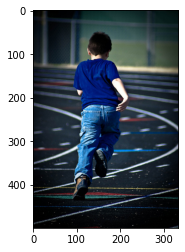

Actual Caption: ['a boy in a blue shirt and blue jeans runs across a playground', 'a boy in blue jeans runs on the track at the local school', 'a boy in jeans runs on a track', 'a boy runs on colorful lines', 'a small boy running track']
Predicted Caption: a man in a white shirt is jumping into a pool
Similarity: 0.8055469632148743



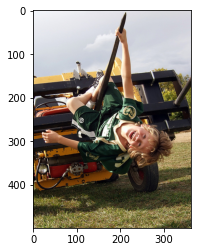

Actual Caption: ['a boy in a green soccer outfit hangs from a machine', 'a boy in a green soccer uniform hangs upside down from a farm vehicle', 'a child hanging from a hay bale loader', 'a young boy is tilted over on a cart smiling at the camera', 'the girl is hanging off of the tractor equipment']
Predicted Caption: a man in a red shirt is walking down the street
Similarity: 0.7432979822158814



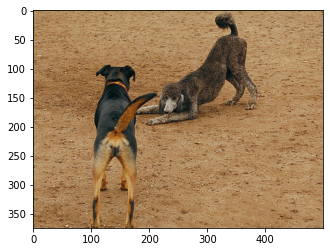

Actual Caption: ['a black and brown dog and a grey poodle sticking its butt in the air on the sand', 'there are two dogs playing in the dirt', 'two bigs dogs play with each other', 'two dogs are playing in the sand', 'two dogs looks at each other while standing on the dirt']
Predicted Caption: a dog is jumping up in the air to catch a ball
Similarity: 0.8267093062400818



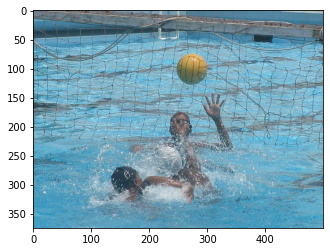

Actual Caption: ['a person hits a yellow volleyball over the net to her opponent in a pool', 'people are playing water volleyball', 'two people play water volleyball in a pool', 'two swimmers are playing a water sport with a yellow ball and a net', 'two swimmers in a pool play at a net with a water polo ball']
Predicted Caption: a boy in a red shirt is jumping into a pool
Similarity: 0.8167412877082825



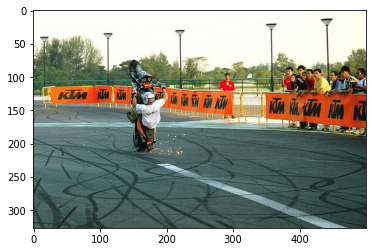

Actual Caption: ['a man does a motorcycle trick on a racetrack while many people watch', 'a man does a wheelie on a motorcycle while a crowd watches', 'a man is pulling a wheelie on a motorcycle whilst being watched by a group of people', 'a motorcycle popping a wheelie in front of a group of people', 'a motorcyclist is about to fall over']
Predicted Caption: a group of people are riding bicycles on a dirt road
Similarity: 0.806071424484253



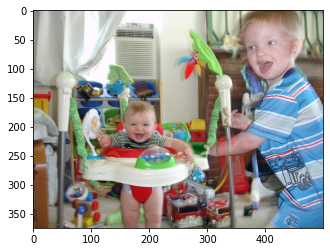

Actual Caption: ['a baby and a toddler are smiling whilst playing in a nursery', 'a baby in a bouncy seat and a standing boy surrounded by toys', 'a baby in a walker and an older child nearby', 'a young boy and his baby brother get excited about picture taking', 'two little boys are smiling and laughing while one is standing and one is in a bouncy seat']
Predicted Caption: a young boy in a red shirt is sitting on a bed with a pacifier in his hand
Similarity: 0.8311070919036865



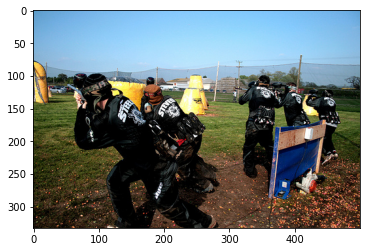

Actual Caption: ['a bunch of guys in black play paintball', 'a group of people wearing body armour while fighting with paintball guns', 'a paintball team shoots', 'some people playing paintball', 'speed ball paintball team starting the first round']
Predicted Caption: a group of people are walking through a field
Similarity: 0.7982080936431885



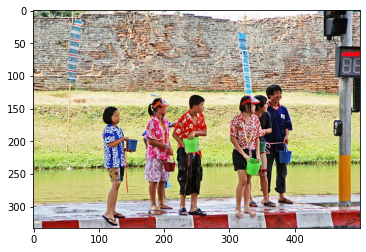

Actual Caption: ['a group of people stand on a stage and hold colorful buckets', 'peolple wearing hawaiian shirts hold buckets by the water', 'people stand on the edge of a waterway striped with red and white where a large wall looms in the background', 'several people stand with water pails', 'six children stand with buckets at a racing dock']
Predicted Caption: a group of people are walking down a street
Similarity: 0.7928520560264587



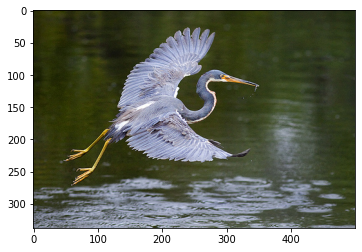

Actual Caption: ['a bird flying over the water', 'a blue bird flying over water', 'a gray bird is flying over the water', 'a large bird spreading his wings in flight over a body of water', 'a large gray bird begins to land in the water']
Predicted Caption: a white bird is flying through the water
Similarity: 0.9178118109703064



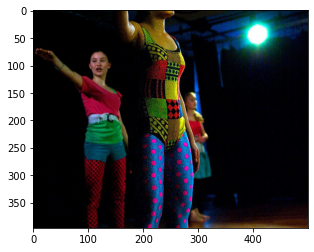

Actual Caption: ['girls dance in colorful outfits', 'the girls standing in a spotlight are dressed in multicolored outfits', 'three girls in colorful outfits are dancing under a stage light', 'three young girls in bright colored clothing are performing in a play', 'women in multicolored outfits are performing on a low light stage']
Predicted Caption: a man in a white shirt is walking down the street
Similarity: 0.721722686290741



In [19]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased",)
test_model = AutoModel.from_pretrained(
    "bert-base-uncased", output_hidden_states=True)


def get_embeddings(text, token_length):
    tokenized_text = tokenizer.tokenize(text)
    if len(tokenized_text) > token_length:
        tokenized_text = tokenized_text[:token_length]
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    with torch.no_grad():
        outputs = test_model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]
    token_vecs = hidden_states[-2][0]
    sentence_embedding = torch.mean(token_vecs, dim=0)
    return sentence_embedding


def calculate_similarity(text1, text2, token_length=20):
    embeddings1 = get_embeddings(text1, token_length)
    embeddings2 = get_embeddings(text2, token_length)
    cos_sim = cosine_similarity(embeddings1.reshape(
        1, -1), embeddings2.reshape(1, -1))[0][0]
    return cos_sim


# predict caption using greedy search
def predict_caption(model, image_id, max_len):
    image_features = id_to_features[image_id]
    in_text = '<start>'
    for i in range(max_len):
        sequence = [word_to_index[w]
                    for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')[0]
        sequence = np.array([sequence])
        y_pred = np.argmax(model.predict(
            [image_features, sequence], verbose=0)[0])
        word = index_to_word[y_pred]
        in_text += ' ' + word
        if word == '<end>':
            break
    final = ' '.join(in_text.split()[1:-1])
    return final


def read_image_by_id(image_id):
    image = load_img("images/Flicker8k_Dataset/" + image_id + ".jpg")
    return image

# a random sample of image_ids
img_ids = list(id_to_features.keys())
np.random.shuffle(img_ids)
img_ids = img_ids[:20]


print('Evaluating our LSTM model with BERT embeddings')
for img_id in img_ids:
    image = read_image_by_id(img_id)
    plt.imshow(image)
    plt.show()
    actual = [' '.join(caption.split(' ')[1:-1])
              for caption in id_to_captions[img_id]]
    print('Actual Caption:', actual)
    prediction = predict_caption(model, img_id, max_len)
    print('Predicted Caption:', prediction)
    similarity = sum(calculate_similarity(caption, prediction, 50)
                     for caption in actual) / len(actual)
    print('Similarity:', similarity)
    print()
